In [52]:
# Import Libraries 
%matplotlib inline
import os
import argparse
import matplotlib
import cv2
import numpy as np
import skimage.graph
import imutils
import csv

from plantcv import plantcv as pcv

In [53]:
class options:
    def __init__(self):
        self.image = "/data/2022_root_robot/trial_seedlings/Input/wavy_roots.tif"
        self.debug = "plot"
        self.writeimg= False
        self.result = "vis_tutorial_results.json"
        self.outdir = "/data/2022_root_robot/trial_seedlings/Output/"
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

In [54]:
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

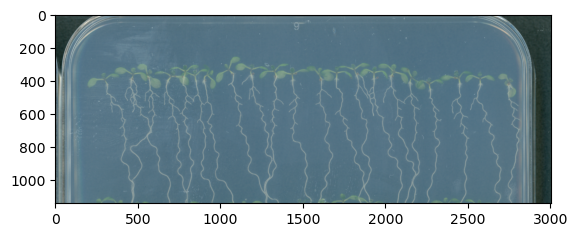

In [55]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img_full, path, filename = pcv.readimage(filename=args.image)

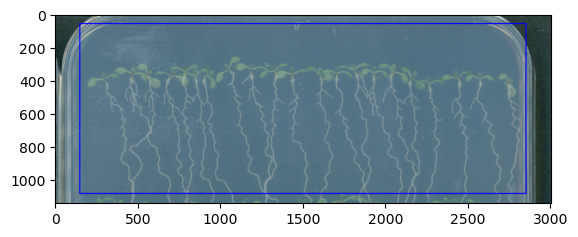

In [56]:
# Crop image
roi_y = int(round(img_full.shape[0] * 0.05))
roi_x = int(round(img_full.shape[1] * 0.05))
roi_h = int(round(img_full.shape[0] - (img_full.shape[0] * 0.1)))
roi_w = int(round(img_full.shape[1] - (img_full.shape[1] * 0.1)))


img = pcv.crop(img=img_full, x=roi_x, y=roi_y, h=roi_h, w=roi_w)

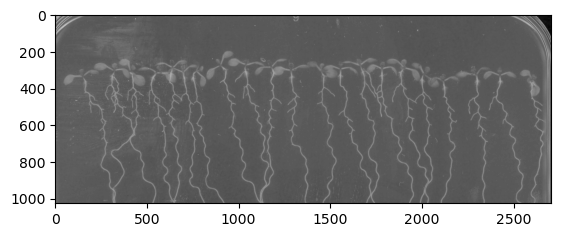

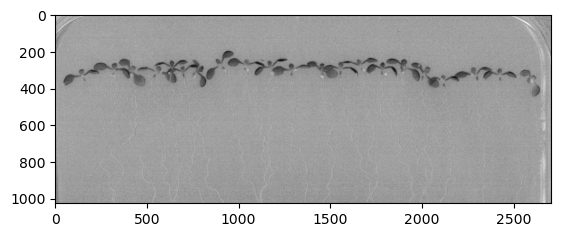

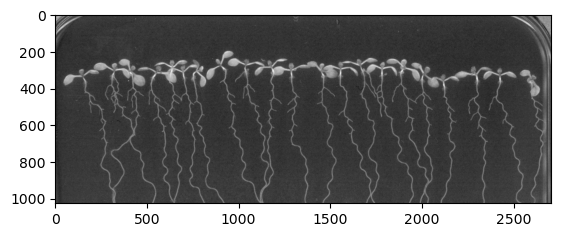

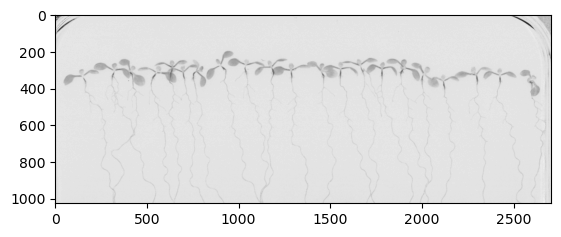

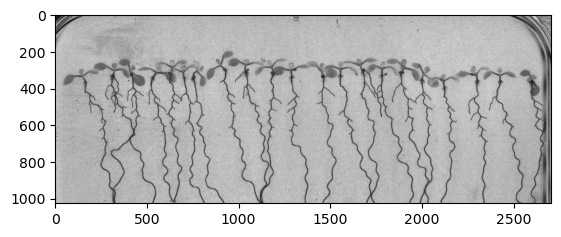

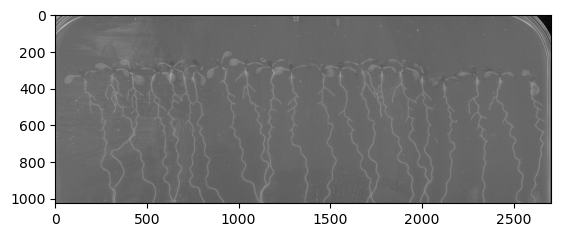

In [57]:
# Inspect LAB and HSV channels
l = pcv.rgb2gray_lab(img, "l")
a = pcv.rgb2gray_lab(img, "a")
b = pcv.rgb2gray_lab(img, "b")

h = pcv.rgb2gray_hsv(img, "h")
s = pcv.rgb2gray_hsv(img, "s")
v = pcv.rgb2gray_hsv(img, "v")

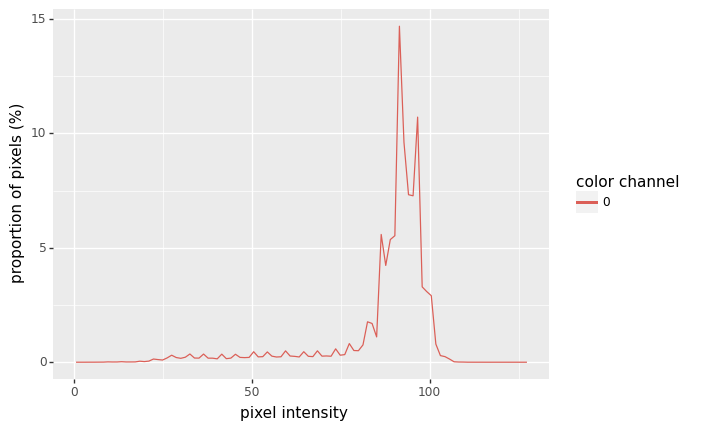

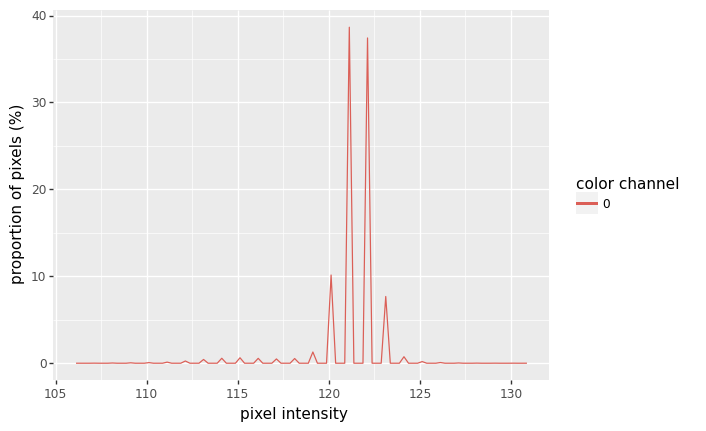

In [58]:
# Plot S (HSV) and A (LAB) channel
hist = pcv.visualize.histogram(img=s)
hist = pcv.visualize.histogram(img=a)

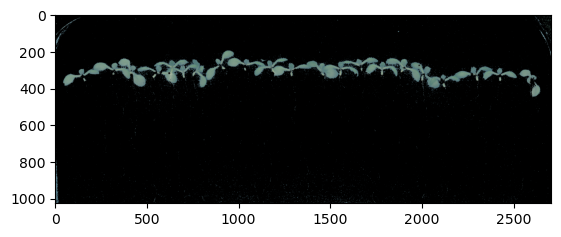

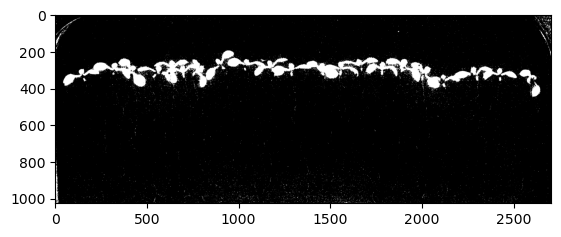

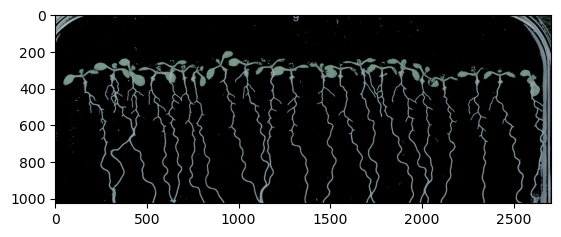

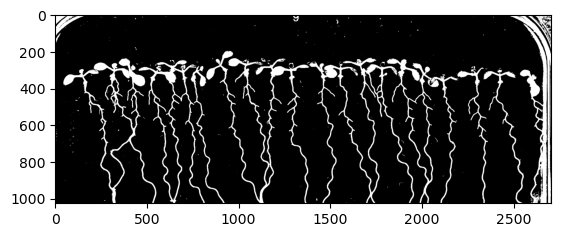

In [59]:
# Mask leaves
leaves, leaves_masked = pcv.threshold.custom_range(img=img, lower_thresh=[0,0,0], upper_thresh=[255,119,255], channel='LAB')
pcv.print_image(leaves_masked, "leaves.png")

# Mask whole plant
plant, plant_masked = pcv.threshold.custom_range(img=img, lower_thresh=[0,0,0], upper_thresh=[255,72,255], channel='HSV')
pcv.print_image(plant_masked, "plant.png")

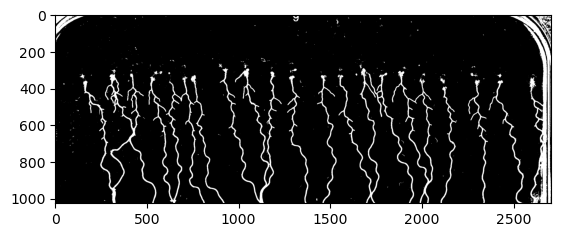

In [60]:
# Subtract leaves from plant
root_raw = pcv.image_subtract(plant, leaves)

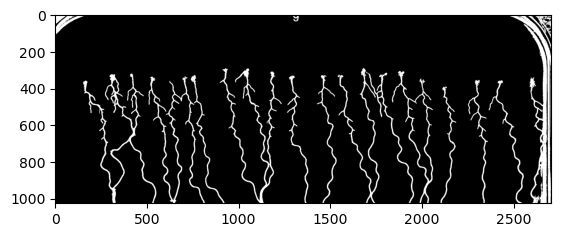

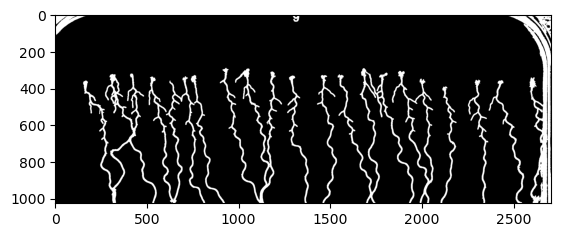

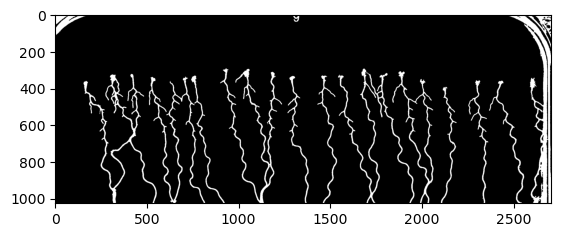

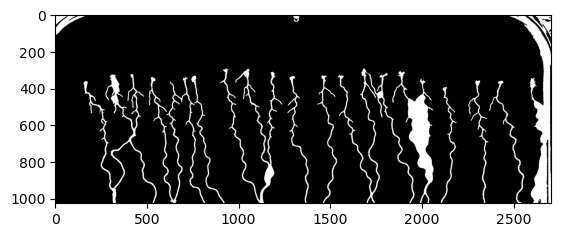

In [61]:
# Remove noise
root_clean = pcv.fill(root_raw, 500)

# Dilate to close gaps
root_dilated = pcv.dilate(root_clean, 2, 2)

# Erode to narrow contour
root_eroded = pcv.erode(root_dilated, 2, 2)

# Fill holes to merge multiple contours per seedling into one
root = pcv.fill_holes(root_eroded)

# Print intermediate output to file
pcv.print_image(root_clean, "clean.png")
pcv.print_image(root_dilated, "dilated.png")
pcv.print_image(root, "segmented.png")

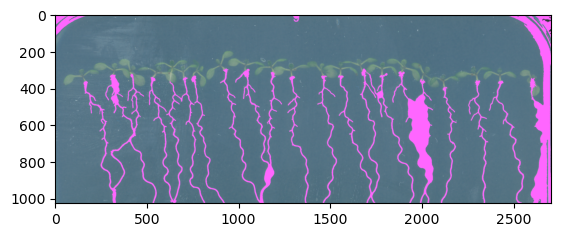

In [62]:
# Find objects
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=root)

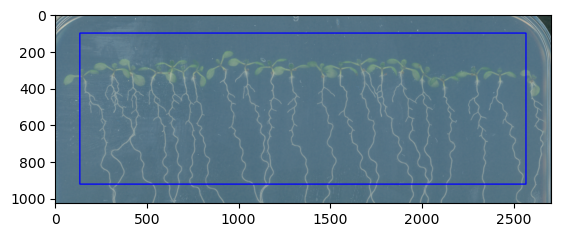

In [63]:
# Define the ROI as a rectangle relative to image size, covering 80% of the width and 60% of the height
roi_y = int(round(img.shape[0] * 0.1))
roi_x = int(round(img.shape[1] * 0.05))
roi_h = int(round(img.shape[0] - (img.shape[0] * 0.2)))
roi_w = int(round(img.shape[1] - (img.shape[1] * 0.1)))

roi_contour, roi_hierarchy = pcv.roi.rectangle(img, x = roi_x, y = roi_y, h = roi_h, w = roi_w)

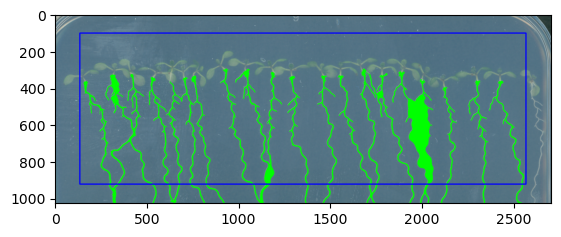

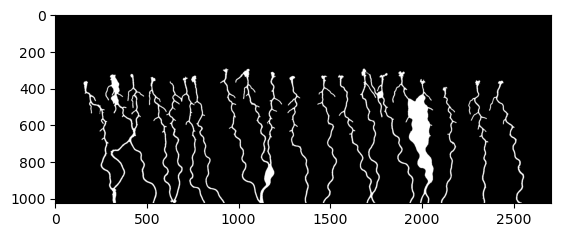

In [64]:
# Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img = img, 
                                                                      roi_type = 'partial', 
                                                                      roi_contour = roi_contour,
                                                                      roi_hierarchy = roi_hierarchy, 
                                                                      object_contour = id_objects, 
                                                                      obj_hierarchy = obj_hierarchy)
pcv.print_image(kept_mask, "mask.png")

There were 0 objects not annotated.


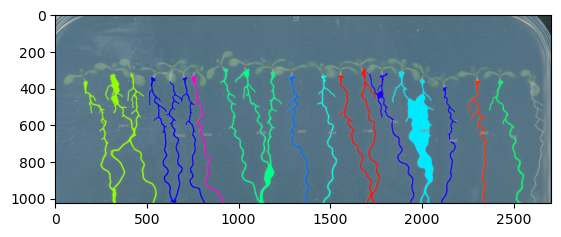

In [65]:
# Print identified objects to file
plotting_img = pcv.visualize.obj_sizes(img=img, mask=kept_mask)
pcv.print_image(plotting_img, "objects.png")

In [66]:
# Define function to find shortest path through a mask
def shortest_path(start,end,binary):
    costs = np.where(binary,1,1000)
    path, cost = skimage.graph.route_through_array(costs, start=start, end=end, fully_connected=True, geometric=True)
    return path,cost

In [67]:
# Create copies of the image for analysis annotations
shape_img = np.copy(img)
root_img = np.copy(img)
skeleton_img = np.copy(img)

# Turn off plot debugging
pcv.params.debug = None

# Write .csv column names
with open(r'root_lengths.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'method', 'seedling ID', 'root length [pixels]', 'height of convex hull'])

# Interate through all objects and do a shape and color analysis
for i in range(0, len(roi_objects)):
    # Check to see if the object has an offshoot in the hierarchy
    if roi_obj_hierarchy[0][i][3] == -1:
        # Create an object and a mask for one object
        seedling, seedling_mask = pcv.object_composition(img=img, contours=[roi_objects[i]], hierarchy=np.array([[roi_obj_hierarchy[0][i]]]))
        
        # Check whether object contains >1 seedling, skip object if true
        M,D,N = seedling.shape
        seedling_reshaped = seedling.reshape((M,2))
        seedling_uniqueX = np.unique(seedling_reshaped[:,1])
        wide_counter = 0

        for j in range(len(seedling_uniqueX)):
            indU = np.where(seedling_reshaped[:,1]==seedling_uniqueX[[j]])
            seedlingX = seedling_reshaped[indU]
            if(len(seedlingX)>1):
                for m in range(len(seedlingX)-1):
                    if(np.abs((seedlingX[m][0]-seedlingX[m+1][0]))>100):
                        wide_counter = wide_counter + 1
                        #print('this is the x,y values: ', seedlingX[m],seedlingX[m+1])
                        
        if wide_counter > 0:
            continue
        
        # Analyze shape of each seed
        shape_img = pcv.analyze_object(img=shape_img, obj=seedling, mask=seedling_mask, label="default")
        root_height = pcv.outputs.observations['default']['height']['value']
        
        # SKELETON
        method = 'skeleton'
        # Skeletonize each seedling
        skeleton_raw = pcv.morphology.skeletonize(mask=seedling_mask)
        skeleton = pcv.dilate(skeleton_raw, 3, 1)
        # Find dilated skeleton contour
        seedling_contour = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c = imutils.grab_contours(seedling_contour)
        # Find y-axis extremes (hypocotyl and root tip)
        hyp = tuple(c[0][c[0][:,:, 1].argmin()][0])
        tip = tuple(c[0][c[0][:,:, 1].argmax()][0])
        # Find shortest path from hypocotyl to root tip through the root skeleton
        primary_root, cost = shortest_path(tip[::-1], hyp[::-1], skeleton)
        primary_root_array = np.flip(np.array(primary_root))
        primary_root_array = primary_root_array.reshape((-1, 1, 2))
        skeleton_img = cv2.polylines(skeleton_img, primary_root_array, True, (69,189,232), 5)
        skeleton_img = cv2.putText(skeleton_img, str(i), hyp, cv2.FONT_HERSHEY_DUPLEX, 1, (69,189,232), 2, cv2.LINE_AA)
        #export data
        with open(r'root_lengths.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow([filename, method, i, cost, root_height])
        
        # CONTOUR
        method = 'contour'
        # Find root contour
        seedling_contour = cv2.findContours(seedling_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c = imutils.grab_contours(seedling_contour)
        # Find y-axis extremes (hypocotyl and root tip)
        hyp = tuple(c[0][c[0][:,:, 1].argmin()][0])
        tip = tuple(c[0][c[0][:,:, 1].argmax()][0])
        # Find shortest path from hypocotyl to root tip through the root contour
        primary_root, cost = shortest_path(tip[::-1], hyp[::-1], seedling_mask)
        primary_root_array = np.flip(np.array(primary_root))
        primary_root_array = primary_root_array.reshape((-1, 1, 2))
        root_img = cv2.polylines(root_img, primary_root_array, True, (69,189,232), 5)
        root_img = cv2.putText(root_img, str(i), hyp, cv2.FONT_HERSHEY_DUPLEX, 1, (69,189,232), 2, cv2.LINE_AA)
        #export data
        with open(r'root_lengths.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow([filename, method, i, cost, root_height])
            

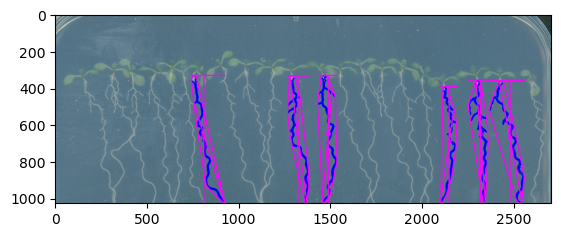

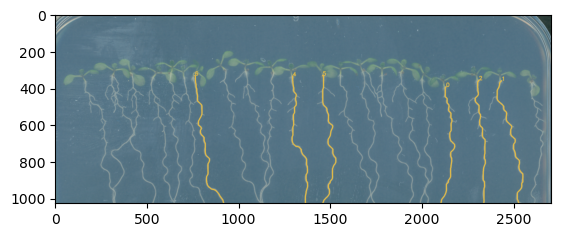

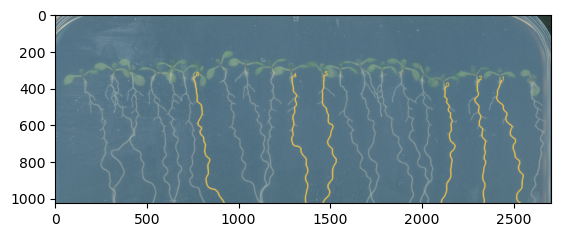

In [68]:
pcv.plot_image(img=shape_img)
pcv.print_image(shape_img, "shape_img.png")
pcv.plot_image(img=root_img)
pcv.print_image(root_img, "root_img.png")
pcv.plot_image(img=skeleton_img)
pcv.print_image(skeleton_img, "skeleton_img.png")